In [10]:
# =============================================================================
# Step 1: Import Libraries and Load Data
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats  # We need this for the F-distribution in our custom test

from statsmodels.multivariate.manova import MANOVA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import levene

print("Libraries imported successfully.")

# Load the clustered customer features dataset we created in the previous notebook
try:
    customer_df = pd.read_csv('../data/customer_features_clustered.csv')
    customer_df.set_index('customer_unique_id', inplace=True)
    print("Clustered data loaded successfully.")
    print(f"Shape of the dataframe: {customer_df.shape}")
except FileNotFoundError:
    print("ERROR: The file '../data/customer_features_clustered.csv' was not found.")
    print("Please make sure you have run the '03-customer-segmentation.ipynb' notebook first.")

# Display the data to make sure it's loaded correctly
customer_df.head()

Libraries imported successfully.
Clustered data loaded successfully.
Shape of the dataframe: (93357, 8)


,Unnamed: 0,recency,frequency,monetary,avg_order_value,product_diversity,tenure,cluster
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,112,1,141.90,141.90,1,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1,115,1,27.19,27.19,1,0,1
0000f46a3911fa3c0805444483337064,2,537,1,86.22,86.22,1,0,0
0000f6ccb0745a6a4b88665a16c9f078,3,321,1,43.62,43.62,1,0,0
0004aac84e0df4da2b147fca70cf8255,4,288,1,196.89,196.89,1,0,0


#Step 2: Define Variables for Analysis

In [11]:
# These are the behavioral features we used for clustering
dependent_vars = ['recency', 'frequency', 'monetary', 'avg_order_value', 'product_diversity', 'tenure']

# This is the segment label assigned by K-Means
independent_var = 'cluster'

print("\nVariables for analysis defined:")
print("Dependent Vars:", dependent_vars)
print("Independent Var:", independent_var)


Variables for analysis defined:
Dependent Vars: ['recency', 'frequency', 'monetary', 'avg_order_value', 'product_diversity', 'tenure']
Independent Var: cluster


Step 5: Implement and Use Custom Hotelling’s T² Test

In [14]:
def hotelling_t2_test(group1, group2):
    """
    Implements the two-sample Hotelling's T-squared test.
    """
    n1, p = group1.shape
    n2, _ = group2.shape
    
    mean1 = np.mean(group1, axis=0)
    mean2 = np.mean(group2, axis=0)
    
    cov1 = np.cov(group1, rowvar=False)
    cov2 = np.cov(group2, rowvar=False)
    
    # Pooled covariance matrix
    S_pooled = ((n1 - 1) * cov1 + (n2 - 1) * cov2) / (n1 + n2 - 2)
    
    # Handle potential singularity by using pseudo-inverse
    try:
        S_inv = np.linalg.inv(S_pooled)
    except np.linalg.LinAlgError:
        S_inv = np.linalg.pinv(S_pooled)
        
    mean_diff = mean1 - mean2
    
    # T-squared statistic
    t_squared = (n1 * n2) / (n1 + n2) * mean_diff.T @ S_inv @ mean_diff
    
    # F-statistic and p-value
    f_stat = (n1 + n2 - p - 1) / ((n1 + n2 - 2) * p) * t_squared
    df1 = p
    df2 = n1 + n2 - p - 1
    p_value = 1 - stats.f.cdf(f_stat, df1, df2)
    
    return t_squared, p_value

# --- Example Usage of Hotelling's T² Test ---
# We'll compare cluster 0 and 1 as an example. 
# You should choose clusters that look interesting after profiling.
print("\n--- Performing Hotelling's T² Test (Example) ---")
group_0_data = customer_df[customer_df['cluster'] == 0][dependent_vars]
group_1_data = customer_df[customer_df['cluster'] == 1][dependent_vars]

t2_stat, p_val = hotelling_t2_test(group_0_data, group_1_data)
print(f"Comparing Cluster 0 vs Cluster 1:")
print(f"  T-squared statistic: {t2_stat:.2f}")
print(f"  p-value: {p_val:.3g}")
if p_val < 0.05:
    print("  -> Result: The two clusters are statistically different.")


# =============================================================================
# Step 6: Profile and Name the Segments
# =============================================================================
print("\n--- Profiling Segments ---")

# Group by cluster and calculate the mean for each feature
segment_profiles = customer_df.groupby('cluster')[dependent_vars].mean()
print("\nSegment Profiles (Means):")
print(segment_profiles)


--- Performing Hotelling's T² Test (Example) ---
Comparing Cluster 0 vs Cluster 1:
  T-squared statistic: 210513.67
  p-value: 1.11e-16
  -> Result: The two clusters are statistically different.

--- Profiling Segments ---

Segment Profiles (Means):
            recency  frequency     monetary  avg_order_value  \
cluster                                                        
0        387.890578   1.012953   160.882868       135.877773   
1        128.780287   1.010206   160.861984       135.937405   
2        142.616231   2.287483   446.849849       146.970820   
3        237.816086   1.019617  2140.859220      1217.786760   
4        232.640496   1.668831   463.490218       181.255446   

         product_diversity      tenure  
cluster                                 
0                 1.000000    0.225995  
1                 1.000000    0.249922  
2                 1.942228  254.053645  
3                 1.008828    0.560078  
4                 2.020071   22.877804  


--- Visualize the Profiles ---

Scale the profiles for a more readable visualization

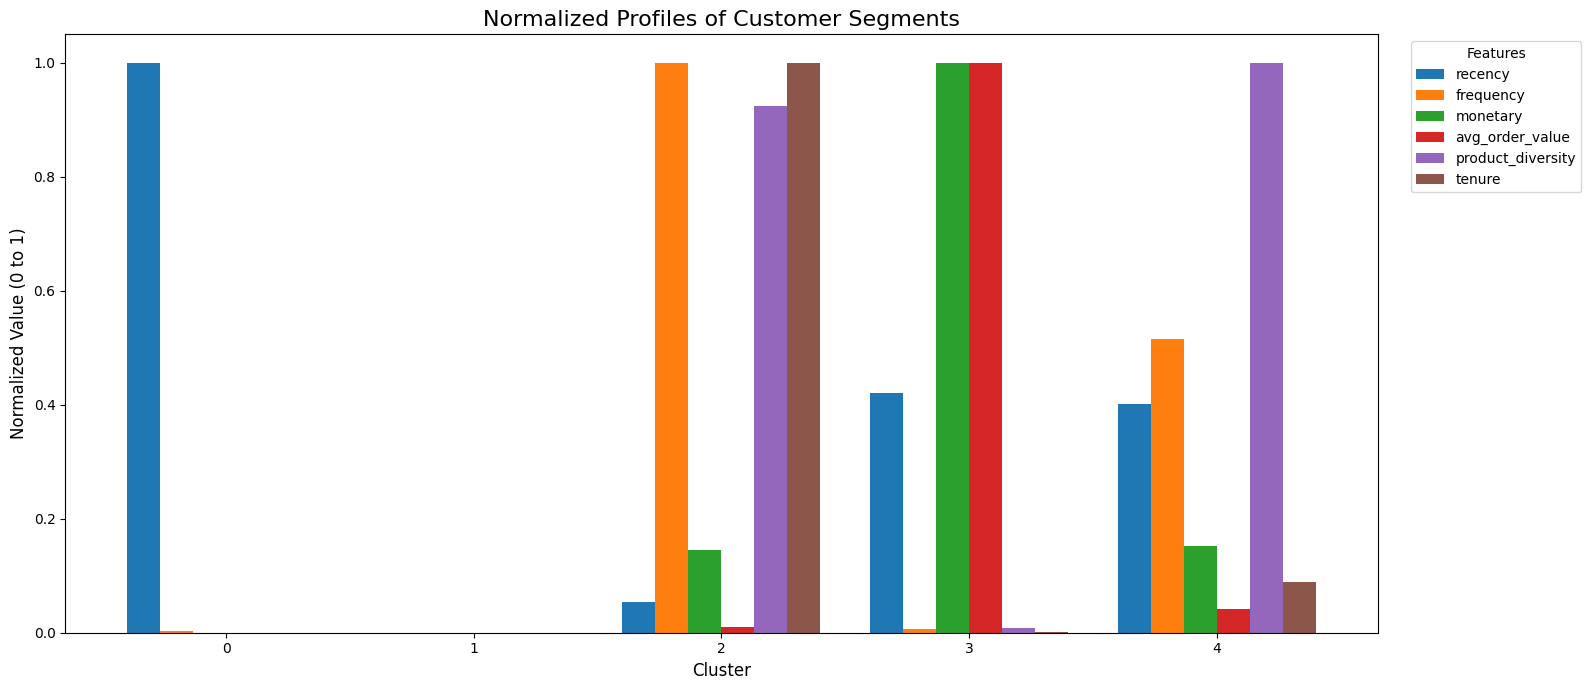

In [19]:
scaler = MinMaxScaler()
profiles_scaled = scaler.fit_transform(segment_profiles)
profiles_scaled_df = pd.DataFrame(profiles_scaled, columns=dependent_vars, index=segment_profiles.index)

# Plotting with bar charts
profiles_scaled_df.plot(kind='bar', figsize=(16, 7), width=0.8)
plt.title('Normalized Profiles of Customer Segments', fontsize=16)
plt.ylabel('Normalized Value (0 to 1)', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Features', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


# --- Name the Segments (Example) ---
# You MUST analyze the profile table and chart above to create these names.
# The names below are placeholders. You need to replace them with your own.
# In your code, replace the placeholder dictionary with this one:
segment_name_map = {
    0: "At-Risk Customers",
    1: "New / One-Time Buyers",
    2: "VIP Champions",
    3: "Big-Ticket Spenders",
    4: "Loyal Regulars"
}


 After analyzing your profiles, update the dictionary above with meaningful names.


In [20]:
# Now, map these accurate names
customer_df['segment_name'] = customer_df['cluster'].map(segment_name_map)

print("\nFinal DataFrame with Segment Names:")
print(customer_df[['recency', 'frequency', 'monetary', 'cluster', 'segment_name']].head())


Final DataFrame with Segment Names:
                                  recency  frequency  monetary  cluster  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2      112          1    141.90        1   
0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     27.19        1   
0000f46a3911fa3c0805444483337064      537          1     86.22        0   
0000f6ccb0745a6a4b88665a16c9f078      321          1     43.62        0   
0004aac84e0df4da2b147fca70cf8255      288          1    196.89        0   

                                           segment_name  
customer_unique_id                                       
0000366f3b9a7992bf8c76cfdf3221e2  New / One-Time Buyers  
0000b849f77a49e4a4ce2b2a4ca5be3f  New / One-Time Buyers  
0000f46a3911fa3c0805444483337064      At-Risk Customers  
0000f6ccb0745a6a4b88665a16c9f078      At-Risk Customers  
0004aac84e0df4da2b147fca70cf8255      At-Risk Customers  


In [23]:
# Save the final dataframe with segment names
customer_df.to_csv('../data/customer_features_clustered_named.csv')
print("\nData with segment names saved to '../data/customer_features_clustered_named.csv'")


Data with segment names saved to '../data/customer_features_clustered_named.csv'
